<br><br>
# Case 3: Patient drug review

### Juha Nuutinen

### 11.03.2019

### Helsinki Metropolia University of Applied Sciences
<br><br>

# Objectives
The aim of this assignment is to learn to use neural networks to process text data and predict ratings associated to the text. The task is to use recurrent and convolutional neural networks to create a predictor for a collection of patient drug reviews extracted from [Drugs.com](https://www.drugs.com). Drugs.com is a comprehensive source of drug information online. The original dataset is explained in [Grässer et al (2018) article](http://kdd.cs.ksu.edu/Publications/Student/kallumadi2018aspect.pdf).

This notebook contains extracts from a [notebook by Sakari Lukkarinen](https://github.com/sakluk/cognitive-systems-for-health-technology/blob/master/Week%207.%20embedding-lstm-gru-and-conv1d.ipynb).

# Required Libraries

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import GRU
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import Sequential
from keras.models import load_model

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import os
print(os.listdir("./input"))

['drugsComTest_raw.csv', 'drugsComTrain_raw.csv']


# Data

### Origin
The data used for this study is from [KUC Hackathon Winter 2018 Kaggle page](https://www.kaggle.com/jessicali9530/kuc-hackathon-winter-2018/home).

### Description
The data is in csv format, and it has already been split into a train and test set. The size of the train set is 161 295, and the size of the test set is 53 766.

The data has the following 7 attributes:
* uniqueID
    * integer id
* drugName
    * string, name of the drug being reviewed
* condition
    * string, the general condition the drug is used for
* review
    * string, the review text
* rating
    * integer rating (0-10)
* date
    * the submit date of the review
* usefulCount
    * integer, the number of times this review has been marked as "useful" by other users

The data has some missing values for the attribute `condition`, but it doesn't affect this study very much, as the goal is to predict the rating of the review.

In [2]:
train_data = pd.read_csv("./input/drugsComTrain_raw.csv")
test_data = pd.read_csv("./input/drugsComTest_raw.csv")
print("Number of test data instances: {}".format(len(test_data)))
train_data.describe(include="all")

Number of test data instances: 53766


,uniqueID,drugName,condition,review,rating,date,usefulCount
count,161297.000000,161297,160398,161297,161297.000000,161297,161297.000000
unique,NaN,3436,884,112329,NaN,3579,NaN
top,NaN,Levonorgestrel,Birth Control,"""Good""",NaN,1-Mar-16,NaN
freq,NaN,3657,28788,33,NaN,146,NaN
mean,115923.585305,NaN,NaN,NaN,6.994377,NaN,28.004755
std,67004.445170,NaN,NaN,NaN,3.272329,NaN,36.403742
min,2.000000,NaN,NaN,NaN,1.000000,NaN,0.000000
25%,58063.000000,NaN,NaN,NaN,5.000000,NaN,6.000000
50%,115744.000000,NaN,NaN,NaN,8.000000,NaN,16.000000
75%,173776.000000,NaN,NaN,NaN,10.000000,NaN,36.000000


In [3]:
train_data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


### Preprocessing

#### Add categorical labels
5 categories for the rating is used:
* rating [9, 10]: very positive
* rating [7, 8]: positive
* rating [5, 6]: neutral
* rating [3, 4]: negative
* rating [1, 2]: very negative

The first step is to add these categories as labels to the data.

In [4]:
# Add categorical label to train data
r = train_data["rating"]
train_labels = -2 * (r <= 2) \
    + -1 * ((r == 3) | (r == 4)) \
    + 1 * ((r == 7) | (r == 8)) \
    + 2 * (r >= 9)
train_data["label"] = train_labels

# And for test data
r = test_data["rating"]
test_labels = -2 * (r <= 2) \
    + -1 * ((r == 3) | (r == 4)) \
    + 1 * ((r == 7) | (r == 8)) \
    + 2 * (r >= 9)
test_data["label"] = test_labels

train_data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,label
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,2
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,1
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,0
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,1
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,2


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E3EF353710>]],
      dtype=object)

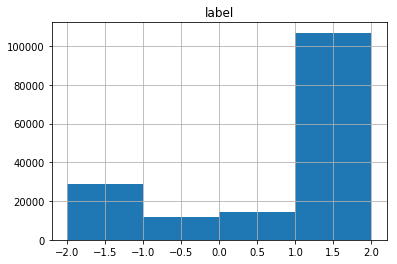

In [5]:
train_data.hist(column = "label", bins = np.arange(-2, 3))

In [6]:
# Convert the labels to categorical
train_cat_labels = to_categorical(train_labels, num_classes = 5)
test_cat_labels = to_categorical(test_labels, num_classes = 5)

#### Compute class weights

In [14]:
class_weights_cmp = compute_class_weight("balanced", [-2, -1, 0, 1, 2], train_labels)
class_weights_cmp

array([1.12992644, 2.79908026, 2.24710226, 1.13805828, 0.4108431 ])

In [38]:
# Categorical convert put the labels in the range 0-4
class_weight = {0: class_weights_cmp[0],
                1: class_weights_cmp[1],
                2: class_weights_cmp[2],
                3: class_weights_cmp[3],
                4: class_weights_cmp[4]}

#### Convert reviews to padded sequences

In [16]:
lengths = train_data["review"].map(str).apply(len)
lengths.describe()

count    161297.000000
mean        458.726238
std         242.130235
min           3.000000
25%         262.000000
50%         455.000000
75%         691.000000
max       10787.000000
Name: review, dtype: float64

In [11]:
n_words = 1000

# The mean of the training set reviews's lengths is about 460.
review_max_len = 500

# Convert training data to padded sequences
train_reviews = train_data["review"]
tokenizer = Tokenizer(n_words)
tokenizer.fit_on_texts(train_reviews)
train_sequences = tokenizer.texts_to_sequences(train_reviews)
x_train = pad_sequences(train_sequences, maxlen = review_max_len)

# Convert test data to padded sequences
test_reviews = test_data["review"]
tokenizer = Tokenizer(n_words)
tokenizer.fit_on_texts(train_reviews)
test_sequences = tokenizer.texts_to_sequences(test_reviews)
x_test = pad_sequences(test_sequences, maxlen = review_max_len)

print("Shape of the training data: ", end="")
print(x_train.shape)
print("Shape of the training labels: ", end="")
print(train_cat_labels.shape)

Shape of the training data: (161297, 500)
Shape of the training labels: (161297, 5)


## Helper functions

In [18]:
def plot_history(history):
    f, ax = plt.subplots(1, 2, figsize = (16, 7))
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.sca(ax[0])
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.sca(ax[1])
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

def train_model(model, x, y, e = 10, bs = 32, v = 1, vs = 0.25, cv = None):
    h = model.fit(x,
                  y,
                  epochs = e,
                  batch_size = bs,
                  verbose = v,
                  validation_split = vs,
                  class_weight = cv)
    return h

## Model 1: Modeling and compilation
According to the [notebook by Sakari Lukkarinen](https://github.com/sakluk/cognitive-systems-for-health-technology/blob/master/Week%207.%20embedding-lstm-gru-and-conv1d.ipynb), a network with an embedding layer, GRU(s), and dropout(s) seems to yield promising results, so that approach is used.

In [55]:
m1 = Sequential()
m1.add(Embedding(n_words, 24, input_length = review_max_len))
m1.add(GRU(12, dropout = 0.1, recurrent_dropout = 0.1, return_sequences = True))
m1.add(GRU(12, dropout = 0.1, recurrent_dropout = 0.1))
m1.add(Dense(5, activation = "softmax"))
m1.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["acc"])
m1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 24)           24000     
_________________________________________________________________
gru_5 (GRU)                  (None, 500, 12)           1332      
_________________________________________________________________
gru_6 (GRU)                  (None, 12)                900       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 65        
Total params: 26,297
Trainable params: 26,297
Non-trainable params: 0
_________________________________________________________________


## Model 1: Training

Train on 120972 samples, validate on 40325 samples
Epoch 1/10
120972/120972 [==============================] - 1015s 8ms/step - loss: 1.1639 - acc: 0.5597 - val_loss: 1.0621 - val_acc: 0.5913
Epoch 2/10
120972/120972 [==============================] - 1006s 8ms/step - loss: 1.0422 - acc: 0.5974 - val_loss: 1.0037 - val_acc: 0.6111
Epoch 3/10
120972/120972 [==============================] - 1034s 9ms/step - loss: 1.0077 - acc: 0.6080 - val_loss: 0.9802 - val_acc: 0.6175
Epoch 4/10
120972/120972 [==============================] - 1041s 9ms/step - loss: 0.9854 - acc: 0.6158 - val_loss: 0.9660 - val_acc: 0.6242
Epoch 5/10
120972/120972 [==============================] - 1075s 9ms/step - loss: 0.9681 - acc: 0.6223 - val_loss: 0.9556 - val_acc: 0.6283
Epoch 6/10
120972/120972 [==============================] - 1038s 9ms/step - loss: 0.9563 - acc: 0.6260 - val_loss: 0.9536 - val_acc: 0.6277
Epoch 7/10
120972/120972 [==============================] - 1042s 9ms/step - loss: 0.9465 - acc: 0.6296

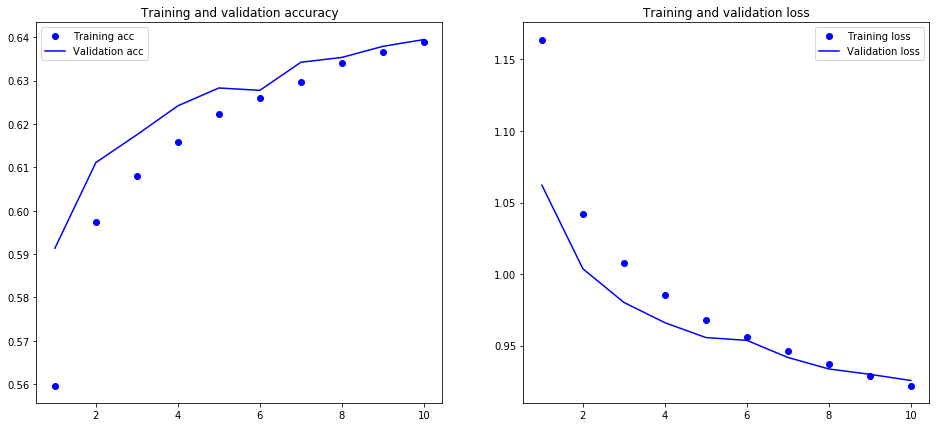

In [56]:
h1 = train_model(m1, x_train, train_cat_labels)
plot_history(h1)

In [57]:
m1.save("m1.h5")

## Model 1: Results
Model 1 was trained for 10 epochs. It didn't manage to learn enough of the data during training, as can be seen from the graphs. Both the training and validation accuracies increase every epoch, and the trend would seem to indicate that they would have continued to increase if the training would have been continued longer.

## Model 2: Modeling and compilation
For the next model, the embedding dimension is increased from 24 to 32. The rest of the model remains the same.

In [58]:
m2 = Sequential()
m2.add(Embedding(n_words, 32, input_length = review_max_len))
m2.add(GRU(12, dropout = 0.1, recurrent_dropout = 0.1, return_sequences = True))
m2.add(GRU(12, dropout = 0.1, recurrent_dropout = 0.1))
m2.add(Dense(5, activation = "softmax"))
m2.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["acc"])
m2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 32)           32000     
_________________________________________________________________
gru_7 (GRU)                  (None, 500, 12)           1620      
_________________________________________________________________
gru_8 (GRU)                  (None, 12)                900       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 65        
Total params: 34,585
Trainable params: 34,585
Non-trainable params: 0
_________________________________________________________________


## Model 2: Training
The second model is trained for more epochs (25 instead of 10), and batch size is also increased from 32 to 56.

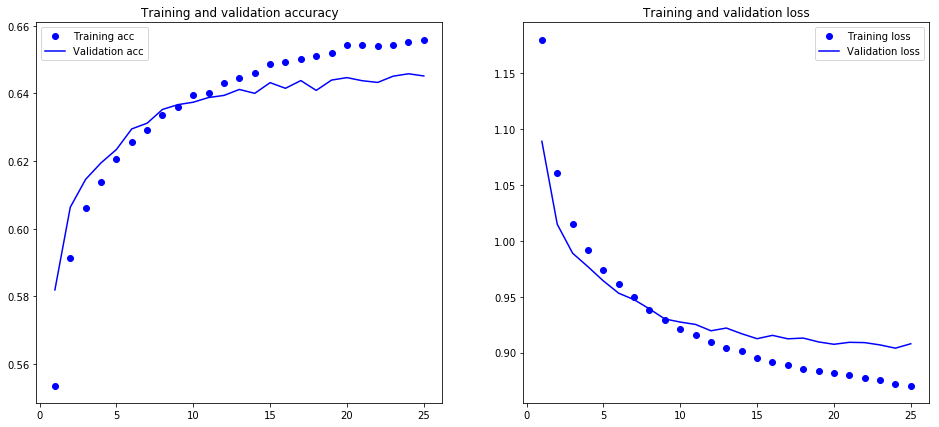

In [61]:
h2 = train_model(m2, x_train, train_cat_labels, e = 25, bs = 56)
plot_history(h2)

In [62]:
m2.save("m2.h5")

## Model 2: Results
Not much better than model 1. Some overfitting is visible from epoch 11 onwards.

## Model 3: Modeling and compilation
The network structure will be kept the same.

In [43]:
m3 = Sequential()
m3.add(Embedding(n_words, 32, input_length = review_max_len))
m3.add(GRU(12, dropout = 0.1, recurrent_dropout = 0.1, return_sequences = True))
m3.add(GRU(12, dropout = 0.1, recurrent_dropout = 0.1))
m3.add(Dense(5, activation = "softmax"))
m3.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["acc"])
m3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 700, 32)           32000     
_________________________________________________________________
gru_9 (GRU)                  (None, 700, 12)           1620      
_________________________________________________________________
gru_10 (GRU)                 (None, 12)                900       
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 65        
Total params: 34,585
Trainable params: 34,585
Non-trainable params: 0
_________________________________________________________________


## Model 3: Training
Class weights are added, and epochs lowered to 15.

Train on 120972 samples, validate on 40325 samples
Epoch 1/15
120972/120972 [==============================] - 888s 7ms/step - loss: 1.9249 - acc: 0.5428 - val_loss: 1.7424 - val_acc: 0.5835
Epoch 2/15
120972/120972 [==============================] - 873s 7ms/step - loss: 1.7068 - acc: 0.5856 - val_loss: 1.6327 - val_acc: 0.5973
Epoch 3/15
120972/120972 [==============================] - 865s 7ms/step - loss: 1.6421 - acc: 0.5986 - val_loss: 1.6054 - val_acc: 0.6063
Epoch 4/15
120972/120972 [==============================] - 866s 7ms/step - loss: 1.6088 - acc: 0.6058 - val_loss: 1.5847 - val_acc: 0.6123
Epoch 5/15
120972/120972 [==============================] - 888s 7ms/step - loss: 1.5810 - acc: 0.6123 - val_loss: 1.5751 - val_acc: 0.6045
Epoch 6/15
120972/120972 [==============================] - 908s 8ms/step - loss: 1.5603 - acc: 0.6175 - val_loss: 1.5504 - val_acc: 0.6161
Epoch 7/15
120972/120972 [==============================] - 928s 8ms/step - loss: 1.5442 - acc: 0.6206 - val_

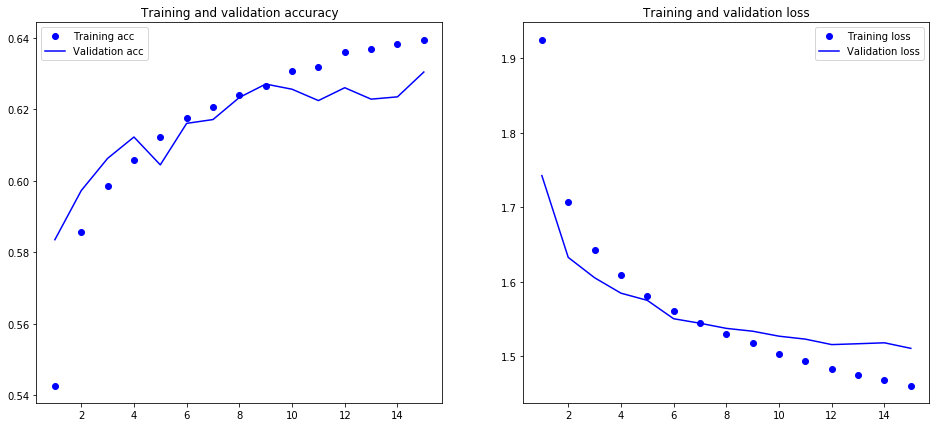

In [44]:
h3 = train_model(m3, x_train, train_cat_labels, e = 15, bs = 56, cv = class_weight)
plot_history(h3)

## Other models
I also experimented with other network structures, however they did not fare any better than these previous models. I tried mixed GRU/Conv1D, and tweaked many of the network parameters.

## Test the best model
Model 2 seems to achieve the best validation accuracy, even though some overfitting is visible.
The final step is to test this model with the reserved test set.

In [76]:
# Load model #2 and predict values using it
model = load_model("m2.h5")
y_pred = model.predict(x_test)

In [92]:
# Convert probabilities to discrete values
y_max = np.argmax(y_pred, axis=1)

y_true = np.argmax(test_cat_labels, axis=1)

cm = confusion_matrix(y_true, y_max)
cr = classification_report(y_true, y_max)
a = accuracy_score(y_true, y_max)
print("Test set confusion matrix:")
print(cm)
print("\nTest set classification report:")
print(cr)
print("\nTest set accuracy score:")
print(a)

Test set confusion matrix:
[[ 1079  1164  1363  1028   195]
 [  624  2234  5792   555    42]
 [  294  1387 23731   749    32]
 [  592   283  1164  7390   204]
 [  808   452   662  1750   192]]

Test set classification report:
              precision    recall  f1-score   support

           0       0.32      0.22      0.26      4829
           1       0.40      0.24      0.30      9247
           2       0.73      0.91      0.81     26193
           3       0.64      0.77      0.70      9633
           4       0.29      0.05      0.08      3864

   micro avg       0.64      0.64      0.64     53766
   macro avg       0.48      0.44      0.43     53766
weighted avg       0.59      0.64      0.60     53766


Test set accuracy score:
0.6440129449838188


Test set accuracy reached about the same accuracy, as the validation during training. The accuracy is not very high. It would probably be higher, if the number of predictable classes would be reduced to for example 3 classes (negative, neutral, positive). Some also say that recurrent neural networks are mode suitable for more complex cases, for example translations, and that for this type of sentiment analysis, classical machine learning methods would be more applicable.